In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [2]:
import os 
from glob import glob
import random
import numpy as np

In [3]:
os.listdir("cropped_dataset/train")

['1', '2', '.ipynb_checkpoints', '0']

In [4]:
train_dir = "cropped_dataset/train" 
test_dir = "cropped_dataset/test"

# fit 데이터셋 만들기

In [5]:
train_path = glob(train_dir+"/*/*.jpg")
test_path = glob(test_dir+"/*/*.jpg")

In [6]:

random.seed(0)
random.shuffle(train_path)
random.shuffle(test_path)
print(train_path[0])
print(test_path[0])

cropped_dataset/train/1/aug_3_0_4612.jpg
cropped_dataset/test/0/aug_1_2_0_3803.jpg


In [7]:
def get_label(filepath):
    return filepath.split("/")[-2]

In [8]:
train_x = []
for file in train_path:
    gfile = tf.io.read_file(file)
    image = tf.io.decode_image(gfile)
    image = tf.image.resize(image, [50, 50])
    image = tf.image.rgb_to_grayscale(image)
    train_x.append(np.asarray(image))

In [9]:
train_y = [get_label(file) for file in train_path]

In [10]:
test_x = []
for file in test_path:
    gfile = tf.io.read_file(file)
    image = tf.io.decode_image(gfile)
    image = tf.image.resize(image, [50, 50])
    image = tf.image.rgb_to_grayscale(image)
    test_x.append(np.asarray(image))

In [11]:
test_y = [get_label(file) for file in test_path]

In [12]:
train_x[10].shape

(50, 50, 1)

In [13]:
type(train_x[0].shape)
print(type(np.array(train_x[0])))

<class 'numpy.ndarray'>


In [14]:
len(train_y)

13395

In [15]:
np.unique(train_y, return_counts=True)

(array(['0', '1', '2'], dtype='<U1'), array([4478, 4419, 4498]))

In [16]:
np.unique(test_y, return_counts=True)

(array(['0', '1', '2'], dtype='<U1'), array([496, 489, 498]))

In [17]:
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

In [18]:
train_x = train_x/255
test_x = test_x/255

In [19]:
train_y = to_categorical(train_y, 3)
test_y = to_categorical(test_y, 3)

In [20]:
train_x.shape

(13395, 50, 50, 1)

In [21]:
train_x = np.squeeze(train_x)
test_x = np.squeeze(test_x)

# build model

### hyperparams

In [22]:
input_shape = (50,50)
batch_size = 5
learning_rate = 0.01
dropout_rate = 0.4
num_classes=3
num_epochs=100

In [23]:
#MODEL_SAVE_FOLDER_PATH = "./model/"
#if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
#    os.mkdir(MODEL_SAVE_FOLDER_PATH)
#MODEL_PATH = MODEL_SAVE_FOLDER_PATH + "fd-" + "{epoch:02d}.hdf5"

In [24]:
#checkpoint = ModelCheckpoint(
#    filepath=MODEL_PATH,
#    monitor="val_loss",
#    verbose=1,
#    save_best_only=True
#)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10
)

### model structure

In [25]:
inputs = layers.Input(input_shape)
net = layers.Flatten()(inputs)

# 1 hidden layer
net = layers.Dense(128)(net)
net = layers.Activation("relu")(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
# 2 hidden layer
net = layers.Dense(128)(net)
net = layers.Activation("relu")(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)

#주의: binary classification에서는 output dense가 1이다 
net = layers.Activation("softmax")(net)
#net = layers.Activation("sigmoid")(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name="NN")

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:
train_y = train_y.astype("int32")
test_y = test_y.astype("int32")

In [28]:
test_y[12]

array([0, 0, 1], dtype=int32)

In [29]:
hist = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Train on 13395 samples, validate on 1483 samples
Epoch 1/100
13395/13395 [==============================] - 7s 489us/sample - loss: 1.1205 - accuracy: 0.3337 - val_loss: 1.0992 - val_accuracy: 0.3297
Epoch 2/100
13395/13395 [==============================] - 5s 361us/sample - loss: 1.0999 - accuracy: 0.3421 - val_loss: 1.1019 - val_accuracy: 0.3345
Epoch 3/100
13395/13395 [==============================] - 5s 368us/sample - loss: 1.1001 - accuracy: 0.3385 - val_loss: 1.1013 - val_accuracy: 0.3297
Epoch 4/100
13395/13395 [==============================] - 5s 373us/sample - loss: 1.1005 - accuracy: 0.3265 - val_loss: 1.0988 - val_accuracy: 0.3358
Epoch 5/100
13395/13395 [==============================] - 5s 399us/sample - loss: 1.1003 - accuracy: 0.3274 - val_loss: 1.0988 - val_accuracy: 0.3358
Epoch 6/100
13395/13395 [==============================] - 6s 477us/sample - loss: 1.1004 - accuracy: 0.3330 - val_loss: 1.1001 - val_accuracy: 0.3345
Epoch 7/100
13395/13395 [====================

In [30]:
model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               320128    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               512      

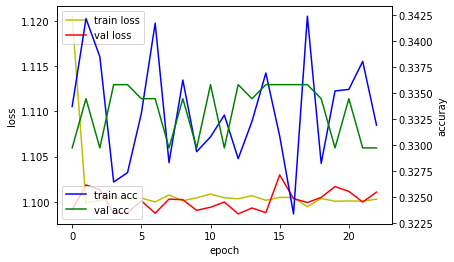

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()